In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/subfolder/Global_local

/content/drive/MyDrive/subfolder/Global_local


In [ ]:
import os
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import time
import h5py
import imutils
import random
import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

In [ ]:
# #read .mat
# # def rgb2gray(rgb):
# #     return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
# K = [14,16,19,21,24,26]
# change = [42, 84, 126, 168, 210,-1]
# ids = list(np.arange(240))
# gratings = []
# t = 0
# with h5py.File('Customized_Gratings/Small_Gratings.mat', 'r')as f:
    
#     print(f['STIM'].shape)
#     print(np.array(f[f['STIM'][0,0]]).shape)
#     num = f['STIM'].shape[0]
# #     for i in range(f['STIM'].shape[0]):
#     for i in ids:
#         if i in change:
#           t += 1
#         k = K[t]
#         a = np.array(f[f['STIM'][i,0]]).copy()
#         a = a[:,1024-k:1024+k,768-k:768+k]
#         gratings.append(a)
# # plt.imshow(a.swapaxes(0,2), cmap=plt.get_cmap('gray'))
# # plt.imshow(a.swapaxes(0,2))
# # plt.show()
# for i in change:
#   plt.imshow(gratings[i-1].swapaxes(0,2))
#   plt.show()
# with open('Customized_Gratings/Small_Gratings.pkl','wb') as f:
#   pickle.dump(gratings,f)

In [ ]:
# read pickle file
with open('Customized_Gratings/Small_Gratings.pkl','rb') as f:
  gratings = pickle.load(f)

In [ ]:
G_train, G_test = train_test_split(gratings,test_size = 0.1, shuffle = True, random_state = 1)

In [ ]:
cls = 9
times = 10
#train index
num = len(G_train)
div = 180/cls
index_tmp = list(np.arange(num))*cls
k = []
for i in range(cls):
  k.extend([i*div]*num)
index_train = [i for i in zip(index_tmp,k)] * times
random.shuffle(index_train)

#test index
num = len(G_test)
div = 180/cls
index_tmp = list(np.arange(num))*cls
k = []
for i in range(cls):
  k.extend([i*div]*num)
index_test = [i for i in zip(index_tmp,k)] * times * 5
random.shuffle(index_test)


In [ ]:
##Random generator for local orientations
##Mixed version: show both global and local orientations

class myDataset():
    """
    Args:
              input input_file_list = [f_content, f_angle]
              target_file_list = f_trans      
              patch_size: int , the cubic patch parameter     
    """
    def __init__(self,input_patches,index,cls = cls, input_size=224):

        self.index = index
        self.inputs = input_patches
        self.input_size = input_size
        self.div = 180/cls
       
    def __len__(self):
        return len(self.index)

    @staticmethod
    def rotate(img,angle):
        return imutils.rotate(img, angle=angle)


    @staticmethod
    ##Randomly distributed with minimum distance
    def random_distributed_with_minimum(n_points,half_distance,boundary_length):
      position = []
      occupied_length = 0
      remain_length = boundary_length 
      def set_first_remain_point(remain_n,remain_length):
          return random.randint(half_distance, remain_length - remain_n * half_distance *2 - half_distance) + occupied_length
      for i in range(n_points,0,-1):
          remain_n = i - 1
          p = set_first_remain_point(remain_n,remain_length)
          occupied_length = p + half_distance
          remain_length = boundary_length - occupied_length
          position.append(p)
      sign = random.randint(0,1)
      if sign:
        position =[(boundary_length - i) for i in position]
      return position
    def __getitem__(self, item):

        idx, angle = self.index[item]  
        img = self.inputs[idx]
        a = img.shape[1]  #half of the patch's side length
        ang = random.randint(1,cls)
        #random rotate locally 
        img = self.rotate(img.swapaxes(0,2),(ang-1)*self.div).swapaxes(0,2)

        #uniform with random shading
        img = img/255*random.uniform(0.5,1)
        #num of gratings & generate random distributed positions
        n = 2 if self.input_size//a == 2 else random.randint(2,self.input_size//a)
        position = self.random_distributed_with_minimum(n,np.int(a//2),self.input_size)
        #Initialize with Gaussian noise
        noise_sigma = random.uniform(0,0.3)
        img0 = np.random.randn(3,self.input_size,self.input_size) * noise_sigma
        img0 = np.zeros((3,self.input_size,self.input_size))
        
        #merge based on random distributed positions
        for i in position:
          # print(int(a//2),i,'\n')
          img0[:,int(self.input_size//2-a//2):int(self.input_size//2+a//2),i-int(a//2):i+int(a//2)] += img

        #rotate globally based on label difference
        img0 = self.rotate(img0.swapaxes(0,2),angle-(ang-1)*self.div).swapaxes(0,2)
        #Initialize with Gaussian noise
        noise_sigma = random.uniform(0,0.3)
        img1 = np.random.randn(3,self.input_size,self.input_size) * noise_sigma
        img0 += img1
        img0 =  (img0-np.min(img0))/(np.max(img0)-np.min(img0))
        label = np.int(angle//self.div)
          

        return torch.from_numpy(img0).float(), label

In [ ]:
batch_size = 275

#set window length
trainset = myDataset(G_train,index_train)
valset = myDataset(G_test,index_test)
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=1)
valloader = DataLoader(valset,batch_size=batch_size, shuffle=True,num_workers=1)

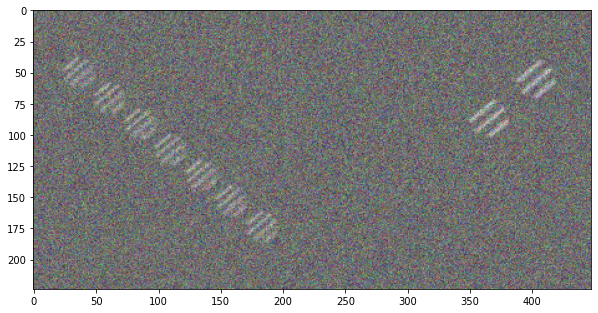

In [ ]:
im = []
plt.figure(figsize = (10,100))
for i in range(40):
  if trainset[i][1] ==7:
    tmp = trainset[i][0].numpy().swapaxes(0,-1).swapaxes(0,1)
    # tmp = imutils.rotate(tmp, angle=90)
    im.append(tmp)
    # plt.imshow(imutils.rotate(tmp, angle=90))
    # plt.show()
img = np.concatenate(im,axis = 1)
plt.imshow(img)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
###Pretrained model

model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model.fc = nn.Dropout(0.5)
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()

In [ ]:
## 17size
import torch.nn as nn
import torch
from torch import autograd

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, input):
        return self.conv(input)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv0 = nn.Conv2d(3, 16, 7, stride=2, padding = 4)  #224
        self.pool0 = nn.MaxPool2d(3,2)
        self.conv1 = DoubleConv(16, 32)  # 56
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(32, 64) # 28
        self.pool2 = nn.MaxPool2d(2)
        # self.conv3 = DoubleConv(64, 128) # 14
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.pool3 = nn.MaxPool2d(2)
        # self.conv4 = DoubleConv(128, 256) # 7
        self.conv4 = nn.Conv2d(128, 256, 3, padding = 1)

        # self.pool4 = nn.MaxPool3d(2)
        # self.conv5 = DoubleConv(256, 512)

        self.fc1 = nn.Linear(256*7*7, 256)
        self.fc2 = nn.Linear(256, cls)
        self.dropout = nn.Dropout(0.5)
        self.dropout0 = nn.Dropout(0.25)
        # self.dropout1 = nn.Dropout(0.5)
    def forward(self, x):
        c0 = self.conv0(x)     
        p0 = F.relu(self.pool0(c0))
        # print(p0.shape)
        c1 = self.conv1(p0)
        p1 = self.pool1(c1)
        # p1 = self.dropout0(p1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        p2 = self.dropout(p2)
        c3 = self.conv3(p2)
        p3 = F.relu(self.pool3(c3))
        p3 = self.dropout(p3)
        c4 = F.relu(self.conv4(p3))
        out = c4.view(-1, 256*7*7)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        # out = nn.LogSoftmax(dim = 1)(x)
        return out

model = CNN()
model.cuda()
model.train()

from torchsummary import summary
summary(model, input_size=(3,224,224))
criterion = nn.CrossEntropyLoss()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 113, 113]           2,368
         MaxPool2d-2           [-1, 16, 56, 56]               0
            Conv2d-3           [-1, 32, 56, 56]           4,640
       BatchNorm2d-4           [-1, 32, 56, 56]              64
              ReLU-5           [-1, 32, 56, 56]               0
            Conv2d-6           [-1, 32, 56, 56]           9,248
       BatchNorm2d-7           [-1, 32, 56, 56]              64
              ReLU-8           [-1, 32, 56, 56]               0
        DoubleConv-9           [-1, 32, 56, 56]               0
        MaxPool2d-10           [-1, 32, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          18,496
      BatchNorm2d-12           [-1, 64, 28, 28]             128
             ReLU-13           [-1, 64, 28, 28]               0
           Conv2d-14           [-1, 64,

In [ ]:
# optimizer = optim.RMSprop(model.parameters(), lr=5e-4, weight_decay=1e-2)
optimizer =  optim.Adam(model.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#optimizer = ScheduledOptim(
#         optim.Adam(
#             filter(lambda x: x.requires_grad, transformer.parameters()),
#             betas=(0.9, 0.98), eps=1e-09),d_model, n_warmup_steps)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


train_loss, train_accu,test_accu_eval,test_loss_eval = [], [], [],[]
t = 0

for epoch in range(50):
    # if epoch == 30:
    #     optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
    # if epoch == 60:
    #     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for images, labels in trainloader:
#         %%capture cap --no-stderr
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model(images) 
        # calls the forward function of model, i.e. model.forward(images)
        # loss = F.nll_loss(outputs, labels)  # calculate loss
        loss = criterion(outputs, labels)
#         loss = nn.CrossEntropyLoss(outputs, labels)
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/len(labels)*100
        train_accu.append(accuracy)
        # mat = np.zeros((cls,cls))
        # for i in range((labels.cpu().numpy().shape[0])):
        #             mat[labels[i],predictions[i]] += 1
        # print(mat)
        if i % 1 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(t, loss.item(), accuracy))
        t += 1
    if epoch%1 == 0 :
        test_loss_tmp = 0
        test_accuracy_tmp = 0 
        num_samples = 0
        model.eval()
        mat = np.zeros((cls,cls))
        for images, labels in valloader:
            with torch.no_grad():
        #         %%capture cap --no-stderr
              # send tensors to GPU
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images) 
                test_loss_tmp += criterion(outputs, labels).item() * len(labels)
          #     optimizer.zero_grad()               # zero the parameter gradients
               
                predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
                test_accuracy_tmp += np.sum(predictions.cpu().numpy()==labels.cpu().numpy())
                num_samples += len(labels)
                for i in range((labels.cpu().numpy().shape[0])):
                    mat[labels[i],predictions[i]] += 1
        for i in range(cls):
            print(mat[i,i]/np.sum(mat,axis = 1)[i])
        test_accu_eval.append(test_accuracy_tmp/num_samples)
        test_loss_eval.append(test_loss_tmp/num_samples)
        print("evalmode: test accu",(test_accuracy_tmp/num_samples))
        print("evalmode: test loss",(test_loss_tmp/num_samples))
        print(mat)
        if test_accuracy_tmp/num_samples >0.97:
          print('Break')
          break
        model.train()

Train Step: 0	Loss: 0.067	Accuracy: 98.909


KeyboardInterrupt: ignored

In [ ]:
checkpoint = {
        "net": model.state_dict(),
        'optimizer':optimizer.state_dict(),
        "epoch": epoch
    }

torch.save(checkpoint, 'CNN_model/checkpoint/model_CNN_local_muilti_angle_%s.pth' %(str(epoch)))


In [ ]:
torch.save(model.state_dict(), "CNN_model/model_CNN_local_muilti_angle")

In [ ]:
#test

model.load_state_dict(torch.load("CNN_model/model_CNN_local_muilti_angle"))
model.eval()
test_loss_tmp = 0
test_accuracy_tmp = 0
num_samples = 0
mat = np.zeros((cls,cls))
print('###eval test on testset')
for images, labels in valloader:
    with torch.no_grad():
#         %%capture cap --no-stderr
      # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images) 
        test_loss_tmp += criterion(outputs, labels).item() * len(labels)
  #     optimizer.zero_grad()               # zero the parameter gradients
        
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        test_accuracy_tmp += np.sum(predictions.cpu().numpy()==labels.cpu().numpy())
        num_samples += len(labels)
        for i in range((labels.cpu().numpy().shape[0])):
            mat[labels[i],predictions[i]] += 1
for i in range(cls):
    print(mat[i,i]/np.sum(mat,axis = 1)[i])
print("evalmode: test accu",(test_accuracy_tmp/num_samples))
print("evalmode: test loss",(test_loss_tmp/num_samples))
print(mat)

test_loss_tmp = 0
test_accuracy_tmp = 0
num_samples = 0
mat = np.zeros((cls,cls))
print('###eval test on trainset')
for images, labels in trainloader:
    with torch.no_grad():
#         %%capture cap --no-stderr
      # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images) 
        test_loss_tmp += criterion(outputs, labels).item() * len(labels)
  #     optimizer.zero_grad()               # zero the parameter gradients
        
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        test_accuracy_tmp += np.sum(predictions.cpu().numpy()==labels.cpu().numpy())
        num_samples += len(labels)
        for i in range((labels.cpu().numpy().shape[0])):
            mat[labels[i],predictions[i]] += 1
for i in range(cls):
    print(mat[i,i]/np.sum(mat,axis = 1)[i])
print("evalmode: train accu",(test_accuracy_tmp/num_samples))
print("evalmode: train loss",(test_loss_tmp/num_samples))
print(mat)

###eval test on testset
0.9575
0.9925
0.9975
0.995
0.9775
0.9975
0.9941666666666666
0.9983333333333333
0.985
evalmode: test accu 0.9883333333333333
evalmode: test loss 0.05738392246335193
[[1.149e+03 0.000e+00 0.000e+00 1.000e+00 4.800e+01 0.000e+00 0.000e+00
  0.000e+00 2.000e+00]
 [0.000e+00 1.191e+03 2.000e+00 7.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00]
 [0.000e+00 3.000e+00 1.197e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00]
 [6.000e+00 0.000e+00 0.000e+00 1.194e+03 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.173e+03 1.000e+00 0.000e+00
  0.000e+00 2.600e+01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.197e+03 0.000e+00
  3.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.193e+03
  7.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00
  1.198e+03 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 

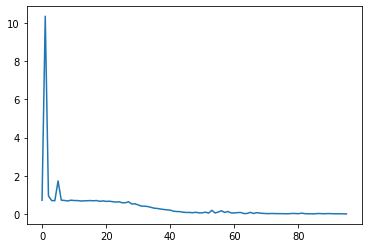

In [ ]:
x = np.arange(len(train_loss)).tolist()
y = train_loss
plt.figure()
plt.plot(x, y)
plt.show()

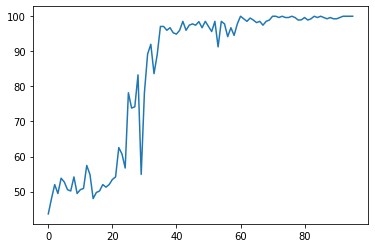

In [ ]:
x = np.arange(len(train_accu)).tolist()
y = train_accu
plt.figure()
plt.plot(x, y)
plt.show()

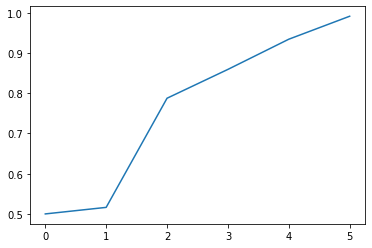

In [ ]:
x = np.arange(len(test_accu_eval)).tolist()
y = test_accu_eval
plt.figure()
plt.plot(x, y)
plt.show()

Global Orientation


In [ ]:
cls = 9
times = 5
#train index
num = len(G_train)
div = 180/cls
index_tmp = list(np.arange(num))*cls
k = []
for i in range(cls):
  k.extend([i*div]*num)
index_train = [i for i in zip(index_tmp,k)] * times
random.shuffle(index_train)

#test index
num = len(G_test)
div = 180/cls
index_tmp = list(np.arange(num))*cls
k = []
for i in range(cls):
  k.extend([i*div]*num)
index_test = [i for i in zip(index_tmp,k)] * times * 5
random.shuffle(index_test)


In [ ]:
##Random generator for global orientations
##Mixed version: show both global and local orientations

class myDataset():
    """
    Args:
              input input_file_list = [f_content, f_angle]
              target_file_list = f_trans      
              patch_size: int , the cubic patch parameter     
    """
    def __init__(self,input_patches,index,cls = cls, input_size=224):

        self.index = index
        random.shuffle(self.index)
        self.inputs = input_patches
        self.input_size = input_size
        self.div = 180/cls
       
    def __len__(self):
        return len(self.index)

    @staticmethod
    def rotate(img,angle):
        return imutils.rotate(img, angle=angle)


    @staticmethod
    ##Randomly distributed with minimum distance
    def random_distributed_with_minimum(n_points,half_distance,boundary_length):
      position = []
      occupied_length = 0
      remain_length = boundary_length 
      def set_first_remain_point(remain_n,remain_length):
          return random.randint(half_distance, remain_length - remain_n * half_distance *2 - half_distance) + occupied_length
      for i in range(n_points,0,-1):
          remain_n = i - 1
          p = set_first_remain_point(remain_n,remain_length)
          occupied_length = p + half_distance
          remain_length = boundary_length - occupied_length
          position.append(p)
      sign = random.randint(0,1)
      if sign:
        position =[(boundary_length - i ) for i in position]
      return position
    def __getitem__(self, item):

        idx, angle = self.index[item]  
        img = self.inputs[idx]
        a = img.shape[1]  #half of the patch's side length
        ang = random.randint(1,cls)
        #random rotate locally 
        img = self.rotate(img.swapaxes(0,2),(ang-1)*self.div).swapaxes(0,2)

        #uniform with random shading
        img = img/255*random.uniform(0.5,1)
        #num of gratings & generate random distributed positions
        n = 2 if self.input_size//a == 2 else random.randint(2,self.input_size//a)
        position = self.random_distributed_with_minimum(n,np.int(a//2),self.input_size)
        
        img0 = np.zeros((3,self.input_size,self.input_size))
        
        #merge based on random distributed positions
        for i in position:
          # print(int(a//2),i,'\n')
          img0[:,int(self.input_size//2-a//2):int(self.input_size//2+a//2),i-int(a//2):i+int(a//2)] += img

        #rotate globally based on label
        img0 = self.rotate(img0.swapaxes(0,2),angle).swapaxes(0,2)
        #Initialize with Gaussian noise
        noise_sigma = random.uniform(0,0.3)
        img1 = np.random.randn(3,self.input_size,self.input_size) * noise_sigma
        img0 += img1
        img0 =  (img0-np.min(img0))/(np.max(img0)-np.min(img0))
        label = np.int(angle//self.div)
          

        return torch.from_numpy(img0).float(), label

In [ ]:
batch_size = 275

#set window length
trainset = myDataset(G_train,index_train)
valset = myDataset(G_test,index_test)
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=1)
valloader = DataLoader(valset,batch_size=batch_size, shuffle=True,num_workers=1)

In [ ]:
im = []
plt.figure(figsize = (10,100))
for i in range(20):
  if trainset[i][1] ==0:
    tmp = trainset[i][0].numpy().swapaxes(0,-1)
    # tmp = imutils.rotate(tmp, angle=90)
    im.append(tmp)
    # plt.imshow(imutils.rotate(tmp, angle=90))
    # plt.show()
im = np.concatenate(im,axis = 1)
plt.imshow(im)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# ###Pretrained model

# model = torchvision.models.resnet18(pretrained=False)
# num_ftrs = model.fc.in_features
# print(num_ftrs)
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model.fc = nn.Dropout(0.5)
# model.fc = nn.Linear(num_ftrs, 2)

# model.to(device)
# model.train()
# criterion = nn.CrossEntropyLoss()

In [ ]:
## 17size
import torch.nn as nn
import torch
from torch import autograd

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, input):
        return self.conv(input)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv0 = nn.Conv2d(3, 16, 7, stride=2, padding = 4)  #224
        self.pool0 = nn.MaxPool2d(3,2)
        self.conv1 = DoubleConv(16, 32)  # 56
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(32, 64) # 28
        self.pool2 = nn.MaxPool2d(2)
        # self.conv3 = DoubleConv(64, 128) # 14
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        self.pool3 = nn.MaxPool2d(2)
        # self.conv4 = DoubleConv(128, 256) # 7
        self.conv4 = nn.Conv2d(128, 256, 3, padding = 1)

        # self.pool4 = nn.MaxPool3d(2)
        # self.conv5 = DoubleConv(256, 512)

        self.fc1 = nn.Linear(256*7*7, 256)
        self.fc2 = nn.Linear(256, cls)
        self.dropout = nn.Dropout(0.5)
        self.dropout0 = nn.Dropout(0.25)
        # self.dropout1 = nn.Dropout(0.5)
    def forward(self, x):
        c0 = self.conv0(x)     
        p0 = F.relu(self.pool0(c0))
        # print(p0.shape)
        c1 = self.conv1(p0)
        p1 = self.pool1(c1)
        # p1 = self.dropout0(p1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        p2 = self.dropout(p2)
        c3 = self.conv3(p2)
        p3 = F.relu(self.pool3(c3))
        p3 = self.dropout(p3)
        c4 = F.relu(self.conv4(p3))
        out = c4.view(-1, 256*7*7)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        # out = nn.LogSoftmax(dim = 1)(x)
        return out

model = CNN()
model.cuda()
model.train()

from torchsummary import summary
summary(model, input_size=(3,224,224))
criterion = nn.CrossEntropyLoss()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 113, 113]           2,368
         MaxPool2d-2           [-1, 16, 56, 56]               0
            Conv2d-3           [-1, 32, 56, 56]           4,640
       BatchNorm2d-4           [-1, 32, 56, 56]              64
              ReLU-5           [-1, 32, 56, 56]               0
            Conv2d-6           [-1, 32, 56, 56]           9,248
       BatchNorm2d-7           [-1, 32, 56, 56]              64
              ReLU-8           [-1, 32, 56, 56]               0
        DoubleConv-9           [-1, 32, 56, 56]               0
        MaxPool2d-10           [-1, 32, 28, 28]               0
           Conv2d-11           [-1, 64, 28, 28]          18,496
      BatchNorm2d-12           [-1, 64, 28, 28]             128
             ReLU-13           [-1, 64, 28, 28]               0
           Conv2d-14           [-1, 64,

In [ ]:
# optimizer = optim.RMSprop(model.parameters(), lr=5e-4, weight_decay=1e-2)
optimizer =  optim.Adam(model.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#optimizer = ScheduledOptim(
#         optim.Adam(
#             filter(lambda x: x.requires_grad, transformer.parameters()),
#             betas=(0.9, 0.98), eps=1e-09),d_model, n_warmup_steps)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


train_loss, train_accu,test_accu_eval,test_loss_eval = [], [], [],[]
t = 0

for epoch in range(20):
    # if epoch == 30:
    #     optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
    # if epoch == 60:
    #     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for images, labels in trainloader:
#         %%capture cap --no-stderr
        # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = model(images) 
        # calls the forward function of model, i.e. model.forward(images)
        # loss = F.nll_loss(outputs, labels)  # calculate loss
        loss = criterion(outputs, labels)
#         loss = nn.CrossEntropyLoss(outputs, labels)
        loss.backward()                     # calculate gradients
        train_loss.append(loss.item())
        optimizer.step()                    # update learnable parameters
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        
        # send tensors back to CPU because numpy ops don't support GPU.
        accuracy = np.sum(predictions.cpu().numpy()==labels.cpu().numpy())/len(labels)*100
        train_accu.append(accuracy)
        # mat = np.zeros((cls,cls))
        # for i in range((labels.cpu().numpy().shape[0])):
        #             mat[labels[i],predictions[i]] += 1
        # print(mat)
        if i % 1 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(t, loss.item(), accuracy))
        t += 1
    if epoch%1 == 0 :
        test_loss_tmp = 0
        test_accuracy_tmp = 0 
        num_samples = 0
        model.eval()
        mat = np.zeros((cls,cls))
        for images, labels in valloader:
            with torch.no_grad():
        #         %%capture cap --no-stderr
              # send tensors to GPU
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images) 
                test_loss_tmp += criterion(outputs, labels).item() * len(labels)
          #     optimizer.zero_grad()               # zero the parameter gradients
               
                predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
                test_accuracy_tmp += np.sum(predictions.cpu().numpy()==labels.cpu().numpy())
                num_samples += len(labels)
                for i in range((labels.cpu().numpy().shape[0])):
                    mat[labels[i],predictions[i]] += 1
        for i in range(cls):
            print(mat[i,i]/np.sum(mat,axis = 1)[i])
        test_accu_eval.append(test_accuracy_tmp/num_samples)
        test_loss_eval.append(test_loss_tmp/num_samples)
        print("evalmode: test accu",(test_accuracy_tmp/num_samples))
        print("evalmode: test loss",(test_loss_tmp/num_samples))
        print(mat)
        if test_accuracy_tmp/num_samples >0.97:
          print('Break')
          break
        model.train()

Train Step: 0	Loss: 2.209	Accuracy: 9.091
Train Step: 1	Loss: 3.406	Accuracy: 10.545
Train Step: 2	Loss: 2.184	Accuracy: 20.364
Train Step: 3	Loss: 2.183	Accuracy: 37.091
Train Step: 4	Loss: 2.131	Accuracy: 33.818
Train Step: 5	Loss: 2.098	Accuracy: 40.364
Train Step: 6	Loss: 2.055	Accuracy: 56.364
Train Step: 7	Loss: 1.858	Accuracy: 69.455
Train Step: 8	Loss: 1.598	Accuracy: 78.909
Train Step: 9	Loss: 1.342	Accuracy: 82.545
Train Step: 10	Loss: 0.976	Accuracy: 85.091
Train Step: 11	Loss: 0.534	Accuracy: 87.636
Train Step: 12	Loss: 0.319	Accuracy: 95.636
Train Step: 13	Loss: 0.202	Accuracy: 95.273
Train Step: 14	Loss: 0.117	Accuracy: 97.455
Train Step: 15	Loss: 0.100	Accuracy: 97.455
Train Step: 16	Loss: 0.066	Accuracy: 97.818
Train Step: 17	Loss: 0.084	Accuracy: 97.818
Train Step: 18	Loss: 0.160	Accuracy: 95.636
Train Step: 19	Loss: 0.033	Accuracy: 98.909
Train Step: 20	Loss: 0.051	Accuracy: 98.545
Train Step: 21	Loss: 0.137	Accuracy: 96.000
Train Step: 22	Loss: 0.068	Accuracy: 97.818

In [ ]:
checkpoint = {
        "net": model.state_dict(),
        'optimizer':optimizer.state_dict(),
        "epoch": epoch
    }

torch.save(checkpoint, 'CNN_model/checkpoint/model_CNN_9angles_%s.pth' %(str(epoch)))


In [ ]:
!ls CNN_model/checkpoint

model_CNN_9angles_0.pth  model_CNN_global_limited_3.pth
model_CNN_global_19.pth  model_CNN_local_limited_5.pth
model_CNN_global_4.pth	 model_CNN_local_muilti_angle_15.pth


In [ ]:
torch.save(model.state_dict(), "CNN_model/model_CNN_global_9angles")

In [ ]:
#test

model.load_state_dict(torch.load("CNN_model/model_CNN_global_9angles"))
model.eval()

test_loss_tmp = 0
test_accuracy_tmp = 0
num_samples = 0
mat = np.zeros((cls,cls))
print('###eval test on testset')
for images, labels in valloader:
    with torch.no_grad():
#         %%capture cap --no-stderr
      # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images) 
        test_loss_tmp += criterion(outputs, labels).item() * len(labels)
  #     optimizer.zero_grad()               # zero the parameter gradients
        
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        test_accuracy_tmp += np.sum(predictions.cpu().numpy()==labels.cpu().numpy())
        num_samples += len(labels)
        for i in range((labels.cpu().numpy().shape[0])):
            mat[labels[i],predictions[i]] += 1
for i in range(cls):
    print(mat[i,i]/np.sum(mat,axis = 1)[i])
print("evalmode: test accu",(test_accuracy_tmp/num_samples))
print("evalmode: test loss",(test_loss_tmp/num_samples))
print(mat)

test_loss_tmp = 0
test_accuracy_tmp = 0
num_samples = 0
mat = np.zeros((cls,cls))
print('###eval test on trainset')
for images, labels in trainloader:
    with torch.no_grad():
#         %%capture cap --no-stderr
      # send tensors to GPU
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images) 
        test_loss_tmp += criterion(outputs, labels).item() * len(labels)
  #     optimizer.zero_grad()               # zero the parameter gradients
        
        predictions = outputs.data.max(1)[1]# column at idx 1 has actual prob.  
        test_accuracy_tmp += np.sum(predictions.cpu().numpy()==labels.cpu().numpy())
        num_samples += len(labels)
        for i in range((labels.cpu().numpy().shape[0])):
            mat[labels[i],predictions[i]] += 1
for i in range(cls):
    print(mat[i,i]/np.sum(mat,axis = 1)[i])
print("evalmode: train accu",(test_accuracy_tmp/num_samples))
print("evalmode: train loss",(test_loss_tmp/num_samples))
print(mat)

###eval test on testset
1.0
0.9966666666666667
0.9783333333333334
1.0
0.9933333333333333
1.0
1.0
1.0
0.9983333333333333
evalmode: test accu 0.9962962962962963
evalmode: test loss 0.012904611843017241
[[600.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1. 598.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 587.  13.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 600.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   4. 596.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 600.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 600.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 600.   0.]
 [  1.   0.   0.   0.   0.   0.   0.   0. 599.]]
###eval test on trainset
1.0
0.9953703703703703
0.9703703703703703
1.0
0.9787037037037037
0.9990740740740741
1.0
1.0
0.9925925925925926
evalmode: train accu 0.9929012345679012
evalmode: train loss 0.018495400232016665
[[1.080e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00]
 [1.000e+00 1.075e+03 4.000e+00 0.000e+00 0.000e+00 0.

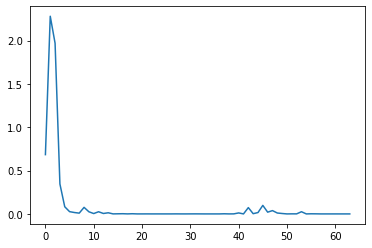

In [ ]:
x = np.arange(len(train_loss)).tolist()
y = train_loss
plt.figure()
plt.plot(x, y)
plt.show()

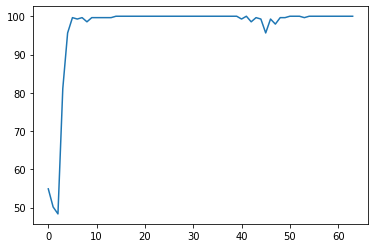

In [ ]:
x = np.arange(len(train_accu)).tolist()
y = train_accu
plt.figure()
plt.plot(x, y)
plt.show()

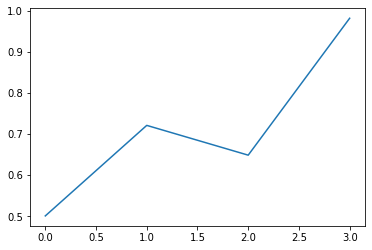

In [ ]:
x = np.arange(len(test_accu_eval)).tolist()
y = test_accu_eval
plt.figure()
plt.plot(x, y)
plt.show()

In [ ]:
####test on ResNet18

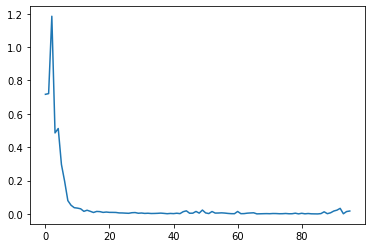

In [ ]:
x = np.arange(len(train_loss)).tolist()
y = train_loss
plt.figure()
plt.plot(x, y)
plt.show()

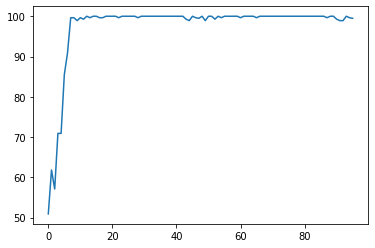

In [ ]:
x = np.arange(len(train_accu)).tolist()
y = train_accu
plt.figure()
plt.plot(x, y)
plt.show()

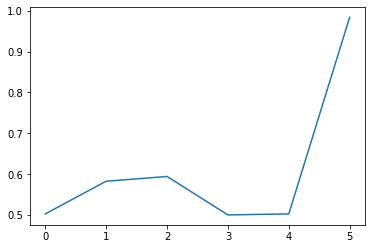

In [ ]:
x = np.arange(len(test_accu_eval)).tolist()
y = test_accu_eval
plt.figure()
plt.plot(x, y)
plt.show()